# Lesson 4c: CLs with a profile likelihood
**[New!]** some really good slides with pictoral descriptions of CLs:
https://indico.in2p3.fr/event/6315/contributions/37805/attachments/30391/37377/sos-lista-1.pdf

Further reading: https://arxiv.org/pdf/hep-ex/9902006.pdf, https://arxiv.org/pdf/1007.1727.pdf (especially the latter!)

Reminder: the "p-value" for a statsitical test is the probability of getting a result at least as extreme as the measured value (or "expected" value, for some expected p-value). The p-value is equivalent to 1 - CL for some interval.

In words:

a measured value $\theta'$ has some probability of being $\leq \theta_{\mbox{max}}$. This ($\theta \leq \theta_{\mbox{max}}$) is a **convidence interval**, and there is a probability, a **confidence level** associated with it occuring.

If the probability distribution for $\theta$ is such that there is a 95% chance of a measured value falling below $\theta_{\mbox{max}}$, then we can say that $\theta$ is less than or equal to $\theta_{\mbox{max}}$ at 95% CL. The inverse of this statement is that there is only a 5% chance of $\theta$ being greater than $\theta_{\mbox{max}}$.

This value, 1 - CL, is the $p$-value. If the CL of our measured result is $> 95\%$, then the p-value is $< 0.05$.

With CLs, we *normalize* the CL of the signal + background hypothesis this to that of the background-only hypothesis: 

\begin{align}
 \mbox{CL}_{s} = \frac{ \mbox{CL}_{s+b}}{ \mbox{CL}_{b}}
\end{align}

where

\begin{align}
\mbox{CL}_{s+b} = P(N \leq N_{\mbox{obs}}; \mu = s+b)
\end{align}
and
\begin{align}
\mbox{CL}_{b}  = P(N \leq N_{\mbox{obs}}; \mu = b) 
\end{align}


Since CL$_{b} \leq 1$, this means that $\mbox{CL}_{s} \geq  \mbox{CL}_{s+b}$. The implications on an experiment are thus that you need a **larger** signal to make an exclusion. This definition is a **conservative** limit. 

Without this normalization, a downward fluctuation in observed events could result in an exclusion, even though the analysis is not sensitive. [Homework: prove this!]

Note that zero signal is never excluded, because $\mbox{CL}_{s=0} =  \mbox{CL}_{s=0+b}/\mbox{CL}_{b} = \mbox{CL}_{b}/\mbox{CL}_{b} =1$.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson,norm,chi2
from scipy import stats
from iminuit import Minuit

Welcome to JupyROOT 6.18/00


In [2]:
%matplotlib notebook

In [3]:
def gaussian(x,mu,sig):
        return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

Last time, we performed a counting experiment and used the number of events as our test statistic.

This time, we'll add in the shape information by performing a profile likelihood. This is what our data looks like:

<IPython.core.display.Javascript object>


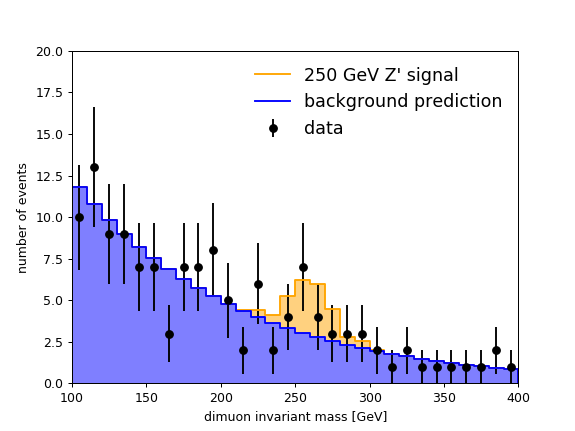

In [47]:
plt.close('all')
x_axis = np.arange(100,400,10)
x_axis_step = np.arange(100,410,10)
#generate the toy data kind of like the text has
bkg_pred = np.exp(x_axis* -0.009) * 29.
sig_pred = 120.*gaussian(x_axis,250,15)

#append some zeros to get the last bin to show up with the step plot (it needs an "end" to the last step!)
bkg_pred_step = np.append(bkg_pred,np.array([0]))
sig_pred_step = np.append(sig_pred,np.array([0]))

obs_evts = [10,13,9,9,7,7,3,7,7,8,5,2,6,2,4,7,4,3,3,3,2,1,2,1,1,1,1,1,2,1]#,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
obs_errors = np.sqrt(obs_evts)

#plot
plt.step(x_axis_step,bkg_pred_step+sig_pred_step,where='post',color='orange',label='250 GeV Z\' signal')
plt.step(x_axis_step,bkg_pred_step,color='blue',where='post',label='background prediction')
plt.errorbar(x_axis+5,obs_evts,yerr=obs_errors,color='black',marker='o',label='data',linestyle='none')

ax = plt.gca()

#make it look like a stacked plot
ax.fill_between(x_axis_step, sig_pred_step+bkg_pred_step, bkg_pred_step, step='post' ,facecolor='orange', alpha=0.5)
ax.fill_between(x_axis_step, bkg_pred_step, 0, step='post' ,facecolor='blue', alpha=0.5)

#labels
ax.set_ylim(bottom=0,top=20)
ax.set_xlim(left=100,right=400)
ax.set_xlabel("dimuon invariant mass [GeV]")
ax.set_ylabel("number of events")

#legend
plt.legend(fontsize=14,loc='upper right',frameon=False)

plt.show()

The likelihood, as we covered in lesson 3, is given by:

\begin{align}
L(\mu_s) = \prod_{\mbox{bins}~~i} f(n_i; \alpha_b*b_i + \mu_s*s_i),
\end{align}

where $n_i$ is the number of observed events in each bin, $b_i$ and $s_i$ are the background and signal predictions, respectively, and $\mu_s$ is the signal strength. The last variable, $\alpha_b$, is the background scale factor. This is our nuisance parameter in the fit - what we allow to float to maximize the likelihood.

The test statistic is the negative log likelihood ratio $t = -2 \ln Q$, where

\begin{align}
Q = \frac{L(\mu_s = 1, \hat{\alpha_b}(\mu_s = 1))}{L(\mu_s = 0, \hat{\alpha_b}(\mu_s = 0))}.
\end{align}

Note that we're taking $\alpha_b$ here to be a scalar quantity: it's the same in every bin. Sometimes, there are other ways of defining this likelihood ratio - whether the signal strength is allowed to float or not, when maximizing the likelihood. This is the convention in ATLAS, but is slightly more complicated, so we'll cover the simpler case here. The more complex case is outlined in https://arxiv.org/pdf/1007.1727.pdf, which the ATLAS statistics forum refers us to in their FAQ.

Let's find the values of $\alpha_b$ that maximuize our likelihood. We do this numerically, by testing multiple values of $\alpha_b$ until we find the lowest possible $-2\ln Q$:

In [7]:
def predicted_yield (a,bkg,s,sig) :
    #s = signal strength
    return a*bkg + s*sig

def likelihood (a, bkg, s, sig, data) :
    pred = predicted_yield(a,bkg, s,sig)
    return stats.poisson.pmf(data, pred)

def log_likelihood (a, bkg,s, sig,data) :
    return np.log(likelihood(a,bkg, s,sig, data))

def TNLL (a,bkg, s,sig, data) :
    return -2. * log_likelihood(a,bkg, s, sig,data)

def likelihood_ratio (a1, s1, a2, s2, bkg, sig, data) :
    l1 = likelihood(a1, s1, data)
    l2 = likelihood(a2, s2, data)
    return l1 / l2

def log_of_likelihood_ratio (a1, s1, a2, s2, bkg, sig, data) :
    return np.log(likelihood_ratio(a1, s1, a2, s2, bkg, sig, data))

def TNLLR (a1, s1, a2, s2, bkg, sig, data) :
    return -2. * log_of_likelihood_ratio(a1, s1, a2, s2, bkg, sig, data)

<IPython.core.display.Javascript object>


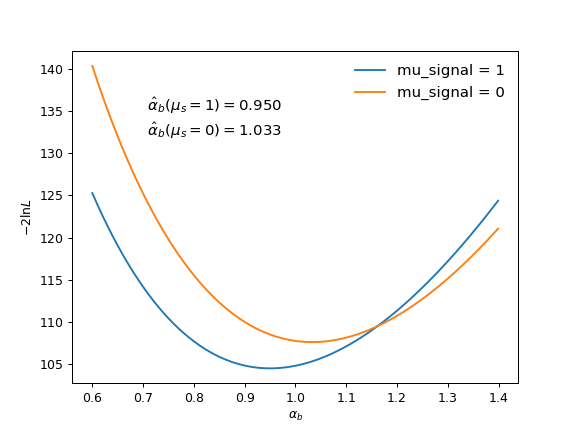

In [41]:
#we'll calculate Q for alpha in increments of 0.001
test_alpha  = np.arange(0.6,1.4,0.001)

#note we can minimize -2 ln L instead of maximizing L itself. Just a little easier!
#tnnl = two negative log likelihood

test_tnlls = []
test_tnlls_mu0 = []

for ta in test_alpha:
    test_tnlls += [-2.*np.log(np.prod(likelihood(ta,bkg_pred,1.0,sig_pred,obs_evts)))]
    test_tnlls_mu0 += [-2.*np.log(np.prod(likelihood(ta,bkg_pred,0,sig_pred,obs_evts)))]

plt.close('all')
plt.plot(test_alpha,test_tnlls, label='mu_signal = 1')
plt.plot(test_alpha,test_tnlls_mu0, label='mu_signal = 0')

#no fancy minimization procedure - just find the min value in the array...
min_alpha_s0 = test_alpha[np.where(test_tnlls_mu0 == np.amin(test_tnlls_mu0))[0]][0]
min_alpha_s1 = test_alpha[np.where(test_tnlls == np.amin(test_tnlls))[0]][0]

plt.text(0.7, 135, r' $\hat\alpha_b (\mu_s = 1) = $'+'{:.3f}'.format(min_alpha_s1), fontsize=12)
plt.text(0.7, 132, r' $\hat\alpha_b (\mu_s = 0) = $'+'{:.3f}'.format(min_alpha_s0), fontsize=12)

#legend
plt.legend(fontsize=12,loc='top right',frameon=False)

ax=plt.gca()
ax.set_xlabel(r"$\alpha_ b$")
ax.set_ylabel(r"$-2\ln L$")


plt.show()

In order to get the *distribution* of the test statistic, we vary the number of signal and background events by varying the number of events in each bin with a poisson distribution.

We use Q as defined above, with the values of $\hat{\alpha_b}$ we found in the previous step.

In order to find the expected confidence limits, we're going to run toy experiments. In these, instead of the expected events being the median of the expected background (for the b-only hypothesis) or the median of the expected background + expected signal (for the signal + background hypothesis), we will **vary** these values under the poisson probability distribution. 

This will give us a reasonable sense of how well we can expect our hypothesis tests to perform with the observed data, under the assumtion that (a) there's no signal, and the background estimation is correct, and (b) there is signal, and our signal+background hypothesis is correct.

In general we do the CLs procedure for multiple signal strengths, and this way you're not dependent on the observed signal existing at some exact cross-section.

Let's run 50000 toy experments:

In [59]:
i = 0
test_bonly = []
test_sb = []

while i < 50000:
    
    #make new arrays with a poisson-varied value in each bin
    #python is nice like this: both bkg_pred and toy_bkg are arrays!
    toy_bkg = poisson.rvs(bkg_pred)
    toy_bkgsig = poisson.rvs(sig_pred+bkg_pred)
    
    #here we calculate the product of the likelihoods of each bin (i.e. L)
    b_ll1 = np.prod(likelihood(min_alpha_s1,bkg_pred,1.0,sig_pred,toy_bkgsig))
    b_ll0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,toy_bkgsig))
    
    b_ll1_0 = np.prod(likelihood(min_alpha_s1,bkg_pred,1.0,sig_pred,toy_bkg))
    b_ll0_0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,toy_bkg))
    
    test_sb += [-2.*np.log(b_ll1/b_ll0)]
    
    test_bonly += [-2*np.log(b_ll1_0/b_ll0_0)]
    
    i += 1

In [101]:
#now we calculate the actual expected and observed values of the test statistic
#need to make the expected events integer for the poisson distribution
b_ll1 = np.prod(likelihood(min_alpha_s1,bkg_pred,1.0,sig_pred,np.array(bkg_pred+sig_pred).astype(int)))
b_ll0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,np.array(bkg_pred+sig_pred).astype(int)))

b_ll1_bonly = np.prod(likelihood(min_alpha_s1,bkg_pred,1.0,sig_pred,np.array(bkg_pred).astype(int)))
b_ll0_bonly = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,np.array(bkg_pred).astype(int)))


b_ll1_0 = np.prod(likelihood(min_alpha_s1,bkg_pred,1.0,sig_pred,obs_evts))
b_ll0_0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,obs_evts))

expected_t =  -2.*np.log(b_ll1/b_ll0)
expected_t_bonly = -2.*np.log(b_ll1_bonly/b_ll0_bonly)
observed_t = -2*np.log(b_ll1_0/b_ll0_0)

<IPython.core.display.Javascript object>


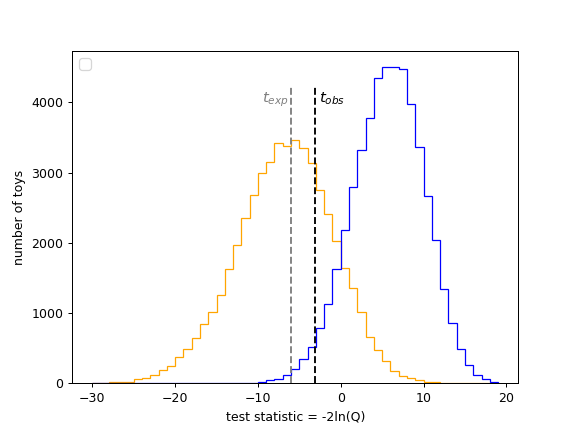

In [60]:
plt.close('all')

#here, we make some histograms matplotlib-style, with set binning -30 --> 20, bin width 1
binning = np.arange(-30,20,1)
plt.hist(test_sb,bins=binning,color='orange', histtype='step')
plt.hist(test_bonly,bins=binning,color='blue',histtype='step')

ax = plt.gca()

ax.set_xlabel("test statistic = -2ln(Q)")

ax.set_ylabel("number of toys") 
#these could also be called toy experiments or pseudo-experiments

ax.axvline(expected_t,0,0.89,color='grey',linestyle='--')
ax.axvline(observed_t,0,0.89,color='black',linestyle='--')

plt.text(expected_t -3.5, 4000, r'$t_{exp}$', fontsize=12,color='grey')
plt.text(observed_t + 0.5, 4000, r'$t_{obs}$', fontsize=12,color='black')

plt.legend(fontsize=12,loc='upper left')

plt.show()

Let's explore some of the values in this plot.

Bring back some handy formulae from the start, now defining them in a continuous way:

\begin{align}
 \mbox{CL}_{s} = \frac{ \mbox{CL}_{s+b}}{ \mbox{CL}_{b}}
\end{align}

where

\begin{align}
\mbox{CL}_{s+b} = \int_{t_{obs}}^{\infty} g(t; s+b) dt
\end{align}
and
\begin{align}
p-\mbox{value} = 1 - \mbox{CL}_{b}  = \int_{-\infty}^{t_{obs}} g(t; b) dt.
\end{align}

Or in a more helpful way for calculating $\mbox{CL}_{s}$,

\begin{align}
\mbox{CL}_{b}  = \int_{t_{obs}}^{\infty} g(t; b) dt.
\end{align}

We can visualize these on our test statstic histogram:

<IPython.core.display.Javascript object>


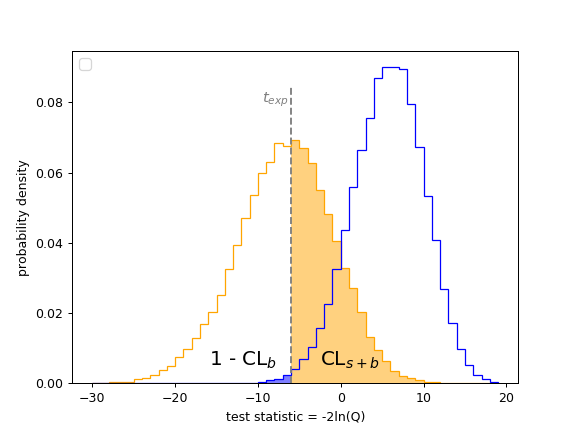

In [124]:
plt.close('all')

#here, we make some histograms matplotlib-style, with set binning -30 --> 20, bin width 1
binning = np.arange(-30,20,1)
n_sb,_,_ = plt.hist(test_sb,bins=binning,normed=1,color='orange', histtype='step')
n_b,_,_ = plt.hist(test_bonly,bins=binning,normed=1,color='blue',histtype='step')

ymin = np.zeros(len(binning)-1)

ax = plt.gca()

ax.set_xlabel("test statistic = -2ln(Q)")

ax.set_ylabel("probability density") 
#these could also be called toy experiments or pseudo-experiments

ax.axvline(expected_t,0,0.89,color='grey',linestyle='--')
plt.text(expected_t -3.5, 0.08, r'$t_{exp}$', fontsize=12,color='grey')

xvals = np.arange(-30,19,1)
#expected_t - 1 just because of binning + integer + non-integer expected values.
ax.fill_between(xvals, n_sb, where=xvals >= expected_t-1, step='post' ,facecolor='orange', alpha=0.5)
ax.fill_between(xvals, n_b, where=xvals <= expected_t, step='post' ,facecolor='blue', alpha=0.5)

plt.text(expected_t+3.5, 0.005, r'CL$_{s+b}$', fontsize=16,color='black')
plt.text(expected_t-10, 0.005, r'1 - CL$_{b}$', fontsize=16,color='black')

plt.legend(fontsize=12,loc='upper left')

plt.show()

In [110]:
#In the histogram above, we're showing the values of CLb and CLs+B under the median 
#signal + background experiment (because we tested the expected value with s+b!).
#Notice that the p-value is really quite small (visually). 

#we can also numerically calculate the values of CLs+b and 1-CLb under each hypothesis!

clb_bonly = 0
clspb_bonly = 0

clb_sb = 0
clspb_sb = 0

clb_data = 0
clspb_data = 0

prob_per_entry = 1./50000. #1 divided by the number of toys...

for tb,tsb in zip(test_bonly,test_sb):
    if tb > expected_t_bonly:
        clb_bonly +=  prob_per_entry
    if tsb > expected_t_bonly:
        clspb_bonly +=  prob_per_entry
    if tb > expected_t:
        clb_sb +=  prob_per_entry
    if tsb > expected_t:
        clspb_sb +=  prob_per_entry
    if tb > observed_t:
        clb_data +=  prob_per_entry
    if tsb > observed_t:
        clspb_data +=  prob_per_entry

cls_bonly = clspb_bonly/clb_bonly
cls_sb = clspb_sb/clb_sb
cls_data = clspb_data/clb_data

print 'expected parameters for the median background-only experiment:'
print '      1 - CLb:',1-clb_bonly
print '      CLs+b:  ',clspb_bonly
print '      CLs:    ',cls_bonly

print 'expected parameters for the median signal+background experiment:'
print '      1 - CLb:',1-clb_sb
print '      CLs+b:  ',clspb_sb
print '      CLs:    ',cls_sb

 expected parameters for the median background-only experiment:
      1 - CLb: 0.50344
      CLs+b:   0.0096
      CLs:     0.0193330111165
expected parameters for the median signal+background experiment:
      1 - CLb: 0.00591999999929
      CLs+b:   0.4583
      CLs:     0.461029293417


Recall that we exclude if CLs < 0.05.

This means that this test has a decent separation - if we observe something that matches the background, CLs = 0.019, which is < 0.05 and we can exclude our signal hypothesis at 95% confidence level.

By varying the expected number of signal events, we can determine exactly what cross-section we can exclude - here, if we do observe data = background, it will be a little higher, because our CLs value is 0.019.

However...

we did not!

So it's a little more fun!

In [111]:
print 'observed parameters for the real data experiment:'
print '      1 - CLb:',1-clb_data
print '      CLs+b:  ',clspb_data
print '      CLs:    ',cls_data

observed parameters for the real data experiment:
      1 - CLb: 0.0259599999993
      CLs+b:   0.26948
      CLs:     0.276662149398


In [112]:
#inverse survival function for a gaussian with mean 0 and width 1 (so in units of sigma)
#for a CLb value of our above experiment
norm.isf(1-clb_data,0,1)

1.943796466923704

So even though 1 - CLb = 0.026, we're only looking at a $1.94\sigma$ deviation (one-sided, so not $> 2\sigma$). 

Time to set limits! But we need to vary the cross-section for this, and the code could get a bit messy, since we need to recalculate the test statistic, $\alpha_b$, and the CLs values for each hypothesis, as a function of $\sigma/\sigma_{nominal}$.

Let's make a function that does lots of this for us.

In [186]:
def get_alpha_mins(bkg_pred,sig_pred,sig_strength,obs_evts):
    
    test_alpha  = np.arange(0.6,1.4,0.001)

    test_tnlls = []
    test_tnlls_mu0 = []

    for ta in test_alpha:
        test_tnlls += [-2.*np.log(np.prod(likelihood(ta,bkg_pred,sig_strength,sig_pred,obs_evts)))]
        test_tnlls_mu0 += [-2.*np.log(np.prod(likelihood(ta,bkg_pred,0,sig_pred,obs_evts)))]
    
    min_alpha_s0 = test_alpha[np.where(test_tnlls_mu0 == np.amin(test_tnlls_mu0))[0]][0]
    min_alpha_s1 = test_alpha[np.where(test_tnlls == np.amin(test_tnlls))[0]][0]
    
    return min_alpha_s0, min_alpha_s1

def get_cl_values(nToys,min_alpha_s0,min_alpha_s1,bkg_pred,sig_pred,sig_strength,obs_evts):

    i = 0
    test_bonly = []
    test_sb = []

    while i < nToys:
    
        #make new arrays with a poisson-varied value in each bin
        #python is nice like this: both bkg_pred and toy_bkg are arrays!
        toy_bkg = poisson.rvs(bkg_pred)
        toy_bkgsig = poisson.rvs(xsval*sig_pred+bkg_pred)
    
        #here we calculate the product of the likelihoods of each bin (i.e. L)
        b_ll1 = np.prod(likelihood(min_alpha_s1,bkg_pred,xsval,sig_pred,toy_bkgsig))
        b_ll0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,toy_bkgsig))
    
        b_ll1_0 = np.prod(likelihood(min_alpha_s1,bkg_pred,xsval,sig_pred,toy_bkg))
        b_ll0_0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,toy_bkg))
    
        test_sb += [-2.*np.log(b_ll1/b_ll0)]
        test_bonly += [-2.*np.log(b_ll1_0/b_ll0_0)]
    
        i += 1

    b_ll1 = np.prod(likelihood(min_alpha_s1,bkg_pred,xsval,sig_pred,np.array(bkg_pred+xsval*sig_pred).astype(int)))
    b_ll0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,np.array(bkg_pred+xsval*sig_pred).astype(int)))

    b_ll1_bonly = np.prod(likelihood(min_alpha_s1,bkg_pred,xsval,sig_pred,np.array(bkg_pred).astype(int)))
    b_ll0_bonly = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,np.array(bkg_pred).astype(int)))

    b_ll1_0 = np.prod(likelihood(min_alpha_s1,bkg_pred,xsval,sig_pred,obs_evts))
    b_ll0_0 = np.prod(likelihood(min_alpha_s0,bkg_pred,0,sig_pred,obs_evts))        

    expected_t =  -2.*np.log(b_ll1/b_ll0)
    expected_t_bonly = -2.*np.log(b_ll1_bonly/b_ll0_bonly)
    observed_t = -2*np.log(b_ll1_0/b_ll0_0)
    
    #find 1, 2 sigma around the expected background with the test_bonly distribution!
    #recall: 1sigma = 34% each side, 2sigma = 47.7% each side
    
    expected_t_bonly_1up = [0,0]
    expected_t_bonly_1down = [0,0]
    expected_t_bonly_2up = [0,0]
    expected_t_bonly_2down = [0,0]

    
    #sort test_bonly for this to work...:
    test_bonly = sorted(test_bonly)
    
    for tb in test_bonly:
        if tb > expected_t_bonly and expected_t_bonly_1up[0] < 0.34:
            expected_t_bonly_1up[0] += 1./nToys
            expected_t_bonly_1up[1] = tb
        if tb > expected_t_bonly and expected_t_bonly_2up[0] < 0.477:
            expected_t_bonly_2up[0] += 1./nToys
            expected_t_bonly_2up[1] = tb

    for tb in reversed(test_bonly):
        if tb < expected_t_bonly and expected_t_bonly_1down[0] < 0.34:
            expected_t_bonly_1down[0] += 1./nToys
            expected_t_bonly_1down[1] = tb
        if tb < expected_t_bonly and expected_t_bonly_2down[0] < 0.477:
            expected_t_bonly_2down[0] += 1./nToys
            expected_t_bonly_2down[1] = tb
        
    clb_bonly = 0
    clspb_bonly = 0    
    clb_bonly_1up = 0
    clspb_bonly_1up = 0    
    clb_bonly_1down = 0
    clspb_bonly_1down = 0    
    clb_bonly_2up = 0
    clspb_bonly_2up = 0    
    clb_bonly_2down = 0
    clspb_bonly_2down = 0

    clb_sb = 0
    clspb_sb = 0

    clb_data = 0
    clspb_data = 0

    prob_per_entry = 1./nToys #1 divided by the number of toys...

    for tb,tsb in zip(test_bonly,test_sb):
        if tb > expected_t_bonly:
            clb_bonly +=  prob_per_entry
        if tsb > expected_t_bonly:
            clspb_bonly +=  prob_per_entry
            
        if tb > expected_t_bonly_1up[1]:
            clb_bonly_1up +=  prob_per_entry
        if tsb > expected_t_bonly_1up[1]:
            clspb_bonly_1up +=  prob_per_entry
            
        if tb > expected_t_bonly_1down[1]:
            clb_bonly_1down +=  prob_per_entry
        if tsb > expected_t_bonly_1down[1]:
            clspb_bonly_1down +=  prob_per_entry
            
        if tb > expected_t_bonly_2up[1]:
            clb_bonly_2up +=  prob_per_entry
        if tsb > expected_t_bonly_2up[1]:
            clspb_bonly_2up +=  prob_per_entry
        
        if tb > expected_t_bonly_2down[1]:
            clb_bonly_2down +=  prob_per_entry
        if tsb > expected_t_bonly_2down[1]:
            clspb_bonly_2down +=  prob_per_entry

        if tb > expected_t:
            clb_sb +=  prob_per_entry
        if tsb > expected_t:
            clspb_sb +=  prob_per_entry
        if tb > observed_t:
            clb_data +=  prob_per_entry
        if tsb > observed_t:
            clspb_data +=  prob_per_entry
  
    cls_bonly = 0
    if clb_bonly > 0: cls_bonly = clspb_bonly/clb_bonly
  
    cls_bonly_1up = 0
    if clb_bonly_1up > 0: cls_bonly_1up = clspb_bonly_1up/clb_bonly_1up
  
    cls_bonly_1down = 0
    if clb_bonly_1down > 0: cls_bonly_1down = clspb_bonly_1down/clb_bonly_1down
  
    cls_bonly_2up = 0
    if clb_bonly_2up > 0: cls_bonly_2up = clspb_bonly_2up/clb_bonly_2up
  
    cls_bonly_2down = 0
    if clb_bonly_2down > 0: cls_bonly_2down = clspb_bonly_2down/clb_bonly_2down
         
    cls_sb = 0
    if clb_sb > 0: cls_sb = clspb_sb/clb_sb
        
    cls_data = 0
    if clb_data > 0:cls_data = clspb_data/clb_data
    
    return [cls_bonly,cls_bonly_1up,cls_bonly_1down,cls_bonly_2up,cls_bonly_2down,
            cls_sb,cls_data]


0.05
0.25
0.45
0.6500000000000001
0.8500000000000001
1.05
1.2500000000000002
1.4500000000000002
1.6500000000000001
1.85


<IPython.core.display.Javascript object>


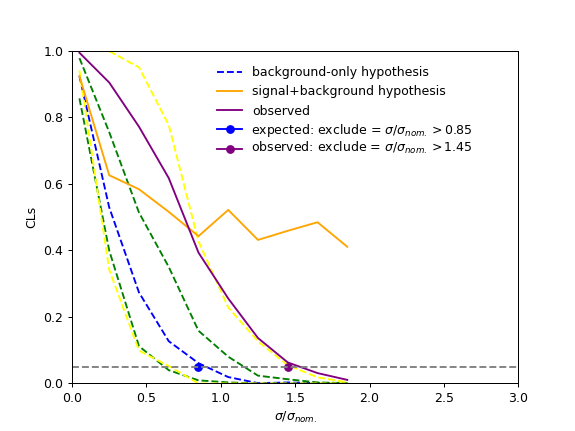

In [188]:
plt.close('all')
#we'll test sigma/sigma_nom between 0 and 2...
xs_over_xsnom = np.arange(0.05,2, 0.2)

cls_vec_obs = []
cls_vec_sb = []
cls_vec_bonly = []
cls_vec_bonly_1up = []
cls_vec_bonly_1down = []
cls_vec_bonly_2up = []
cls_vec_bonly_2down = []

exp_005 = [0,999]


obs_005 = [0,999]

#here we'll do the full CLs calculation for each XS. It's gonna be a long one, 
#since we need to run our toys in each case. so let's start with 5000 toys...

for xsval in xs_over_xsnom:
    
    print xsval
    
    min_alpha_s0,min_alpha_s1 = get_alpha_mins(bkg_pred,sig_pred,xsval,obs_evts)
    clvals = get_cl_values(2000,min_alpha_s0,min_alpha_s1,bkg_pred,sig_pred,xsval,obs_evts)

    cls_vec_obs += [clvals[6]]
    cls_vec_sb += [clvals[5]]
    cls_vec_bonly += [clvals[0]]

    cls_vec_bonly_1up += [clvals[1]]
    cls_vec_bonly_1down += [clvals[2]]
    cls_vec_bonly_2up += [clvals[3]]
    cls_vec_bonly_2down += [clvals[4]]
    
    if abs(clvals[0] - 0.05) < exp_005[1]:
        exp_005[1] = abs(clvals[0] - 0.05)
        exp_005[0] = xsval
    if abs(clvals[6] - 0.05) < obs_005[1]:
        obs_005[1] = abs(clvals[6] - 0.05)
        obs_005[0] = xsval

exp_str = "{:.2f}".format(exp_005[0])
obs_str = "{:.2f}".format(obs_005[0])

plt.plot(xs_over_xsnom, cls_vec_bonly, color='blue',label="background-only hypothesis",linestyle = '--')

plt.plot(xs_over_xsnom, cls_vec_bonly_1up, color='green',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_1down, color='green',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_2up, color='yellow',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_2down, color='yellow',linestyle = '--')

plt.plot(xs_over_xsnom, cls_vec_sb, color='orange',label="signal+background hypothesis")
plt.plot(xs_over_xsnom, cls_vec_obs, color='purple',label="observed")
plt.plot([exp_005[0]],[0.05],color='blue',marker='o',label = " ")
plt.plot([obs_005[0]],[0.05],color='purple',marker='o',label = " ")

ax = plt.gca()
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=2)
ax.set_xlabel(r'$\sigma$/$\sigma_{nom.}$')
ax.set_ylabel("CLs")

ax.axhline(0.05,0,5,color='grey',linestyle='--')

plt.text(1.2, 0.75, 'expected: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+exp_str,fontsize=10,color='black')
plt.text(1.2, 0.695, 'observed: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+obs_str,fontsize=10,color='black')


plt.legend(fontsize=10,loc='lower left',frameon=False,bbox_to_anchor=(0.3,0.65))

plt.show()

Now I have this pre-run with better granularity in xs and a larger number of toys... 

In [189]:
#we'll test sigma/sigma_nom between 0 and 5...
xs_over_xsnom = np.arange(0.05,3, 0.05)

cls_vec_obs = []
cls_vec_sb = []
cls_vec_bonly = []
cls_vec_bonly_1up = []
cls_vec_bonly_1down = []
cls_vec_bonly_2up = []
cls_vec_bonly_2down = []

exp_005 = [0,999]


obs_005 = [0,999]

#here we'll do the full CLs calculation for each XS. It's gonna be a long one, 
#since we need to run our toys in each case. so let's start with 5000 toys...

for xsval in xs_over_xsnom:
    
    print xsval
    
    min_alpha_s0,min_alpha_s1 = get_alpha_mins(bkg_pred,sig_pred,xsval,obs_evts)
    clvals = get_cl_values(4000,min_alpha_s0,min_alpha_s1,bkg_pred,sig_pred,xsval,obs_evts)

    cls_vec_obs += [clvals[6]]
    cls_vec_sb += [clvals[5]]
    cls_vec_bonly += [clvals[0]]

    cls_vec_bonly_1up += [clvals[1]]
    cls_vec_bonly_1down += [clvals[2]]
    cls_vec_bonly_2up += [clvals[3]]
    cls_vec_bonly_2down += [clvals[4]]
    
    if abs(clvals[0] - 0.05) < exp_005[1]:
        exp_005[1] = abs(clvals[0] - 0.05)
        exp_005[0] = xsval
    if abs(clvals[6] - 0.05) < obs_005[1]:
        obs_005[1] = abs(clvals[6] - 0.05)
        obs_005[0] = xsval

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95


<IPython.core.display.Javascript object>


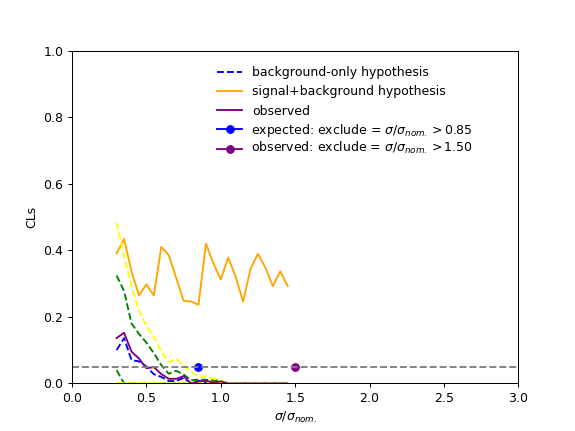

In [194]:
plt.close('all')
exp_str = "{:.2f}".format(exp_005[0])
obs_str = "{:.2f}".format(obs_005[0])

plt.plot(xs_over_xsnom, cls_vec_bonly, color='blue',label="background-only hypothesis",linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_sb, color='orange',label="signal+background hypothesis")

plt.plot(xs_over_xsnom, cls_vec_bonly_1up, color='green',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_1down, color='green',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_2up, color='yellow',linestyle = '--')
plt.plot(xs_over_xsnom, cls_vec_bonly_2down, color='yellow',linestyle = '--')

plt.plot(xs_over_xsnom, cls_vec_obs, color='purple',label="observed")
plt.plot([exp_005[0]],[0.05],color='blue',marker='o',label = " ")
plt.plot([obs_005[0]],[0.05],color='purple',marker='o',label = " ")

ax = plt.gca()
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=3)
ax.set_xlabel(r'$\sigma$/$\sigma_{nom.}$')
ax.set_ylabel("CLs")

ax.axhline(0.05,0,5,color='grey',linestyle='--')

plt.text(1.2, 0.75, 'expected: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+exp_str,fontsize=10,color='black')
plt.text(1.2, 0.695, 'observed: exclude = '+r'$\sigma$/$\sigma_{nom.} > $'+obs_str,fontsize=10,color='black')


plt.legend(fontsize=10,loc='lower left',frameon=False,bbox_to_anchor=(0.3,0.65))

plt.show()

We're only really missing two parts now:

(1) the uncertainties

(2) other mass hypotheses

We did the uncertainties before - that's just varying the expected number of background events and recalculating the cross-section value for CLs < 0.05.

What about varying the mass hypothesis? We've just done 250 GeV.

```sig_pred = 120.*gaussian(x_axis,250,15)```

Let's try with 150, 200, 250, 300, 350 GeV, and add in the 1/2 sigma bands at the same time.

I'll play around a little with nToys and the parameters of the XS scan to make sure this runs as fast as possible (these are things you'd do with the real CLs as well!)



In [192]:
exp_005_250 = exp_005[0]
obs_005_250 = obs_005[0]

masses = [150,200,250,300,350]

exp_limits = []
exp_limits_1up = []
exp_limits_1down = []
exp_limits_2up = []
exp_limits_2down = []

obs_limits = []

xs_over_xsnom = np.arange(0.3,1.5, 0.05)

for mass in masses:
    print 'running: ', mass

    mass_sig_pred = 120.*gaussian(x_axis,mass,15) 

    cls_vec_obs = []
    cls_vec_sb = []
    cls_vec_bonly = []
    cls_vec_bonly_1up = []
    cls_vec_bonly_1down = []
    cls_vec_bonly_2up = []
    cls_vec_bonly_2down = []

    tmp_exp_005 = [0,999]
    
    tmp_exp_005_1up = [0,999]
    tmp_exp_005_1down = [0,999]
    tmp_exp_005_2up = [0,999]
    tmp_exp_005_2down = [0,999]

    tmp_obs_005 = [0,999]

    for xsval in xs_over_xsnom:
    
        min_alpha_s0,min_alpha_s1 = get_alpha_mins(bkg_pred,mass_sig_pred,xsval,obs_evts)
        clvals = get_cl_values(800,min_alpha_s0,min_alpha_s1,bkg_pred,mass_sig_pred,xsval,obs_evts)

        cls_vec_obs += [clvals[6]]
        cls_vec_sb += [clvals[5]]
        cls_vec_bonly += [clvals[0]]
        
        cls_vec_bonly_1up += [clvals[1]]
        cls_vec_bonly_1down += [clvals[2]]
        cls_vec_bonly_2up += [clvals[3]]
        cls_vec_bonly_2down += [clvals[4]]
    
        if abs(clvals[0] - 0.05) < tmp_exp_005[1]:
            tmp_exp_005[1] = abs(clvals[0] - 0.05)
            tmp_exp_005[0] = xsval
            
        if abs(clvals[1] - 0.05) < tmp_exp_005_1up[1]:
            tmp_exp_005_1up[1] = abs(clvals[1] - 0.05)
            tmp_exp_005_1up[0] = xsval
        if abs(clvals[2] - 0.05) < tmp_exp_005_1down[1]:
            tmp_exp_005_1down[1] = abs(clvals[2] - 0.05)
            tmp_exp_005_1down[0] = xsval
        if abs(clvals[3] - 0.05) < tmp_exp_005_2up[1]:
            tmp_exp_005_2up[1] = abs(clvals[3] - 0.05)
            tmp_exp_005_2up[0] = xsval
        if abs(clvals[4] - 0.05) < tmp_exp_005_2down[1]:
            tmp_exp_005_2down[1] = abs(clvals[4] - 0.05)
            tmp_exp_005_2down[0] = xsval
            
        if abs(clvals[6] - 0.05) < tmp_obs_005[1]:
            tmp_obs_005[1] = abs(clvals[6] - 0.05)
            tmp_obs_005[0] = xsval
            
    exp_limits += [tmp_exp_005[0]]
    
    exp_limits_1up += [tmp_exp_005_1up[0]]
    exp_limits_1down += [tmp_exp_005_1down[0]]
    exp_limits_2up += [tmp_exp_005_2up[0]]
    exp_limits_2down += [tmp_exp_005_2down[0]]
    
    obs_limits += [tmp_obs_005[0]]

running:  150
running:  200
running:  250
running:  300
running:  350


And finally, to wrap this up, we'll make the plot a little more recognizable:

<IPython.core.display.Javascript object>


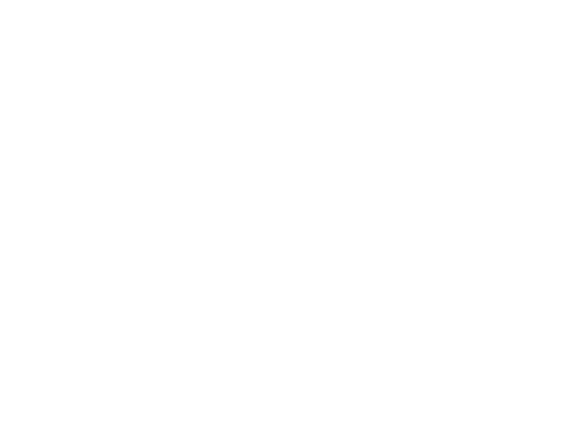

In [193]:
plt.close('all')

ax = plt.gca()

ax.fill_between(masses, exp_limits_2down, exp_limits_2up,  step='pre' ,facecolor='yellow', alpha=0.7,label='2 sigma')
ax.fill_between(masses, exp_limits_1down, exp_limits_1up,  step='pre' ,facecolor='green', alpha=0.7,label ='1 sigma')

plt.plot(masses,exp_limits,color='black',linestyle = '--',label = "expected limit")
plt.plot(masses,obs_limits,color='black',label = "observed limit")


ax.set_ylim(bottom=0,top=3)
ax.set_xlim(left=100,right=400)
ax.set_ylabel(r'excluded $\sigma$/$\sigma_{nom.}$')
ax.set_xlabel("Z' mass [GeV]")

plt.legend(fontsize=10,loc='bottom left',frameon=False,bbox_to_anchor=(0.5,0.6))

plt.show()